In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import nn
from torch.utils.data import DataLoader

In [2]:
print(torch.__version__)
print(torch.cuda.is_available())

2.3.0+cu121
False


## Chuẩn bị dữ liệu

Bài toán phân loại ảnh trang phục hàng ngày, sử dụng bộ dữ liệu Fashion MNIST. Bộ dữ liệu này tương tự MNIST gồm các ảnh đen trắng (grayscale) kích thước $28 \times 28$, với giá trị pixel nằm trong đoạn $[0, 1]$. Mỗi ảnh tương ứng với ảnh của một trong 10 loại trang phục.

Bộ dữ liệu gồm 70000 ảnh đã được gán nhãn, được chia thành hai tập dữ liệu: training gồm 60000 ảnh và testing gồm 10000 còn lại.

In [3]:
train_data = datasets.FashionMNIST(root='data', train=True, download=True, transform=ToTensor())
test_data  = datasets.FashionMNIST(root='data', train=False, download=True, transform=ToTensor())

100%|██████████| 26421880/26421880 [00:01<00:00, 18193076.47it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 319441.81it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5377327.72it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5281868.15it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



torch.Size([1, 28, 28])
Train data size = 60000
Test  data size = 10000
Input size = torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Coat')

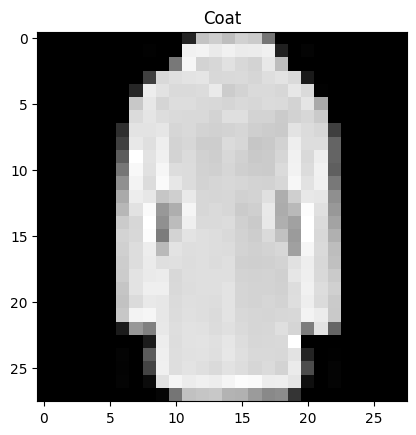

In [4]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
    }
print(train_data[0][0].shape)
print(f"Train data size = {len(train_data)}")
print(f"Test  data size = {len(test_data)}")
print(f"Input size = {train_data[0][0].shape}")
k = torch.randint(0, 1024, (1,)).item()
plt.imshow(train_data[k][0][0,:,:], cmap='gray', vmin=0.0, vmax=1.0)
plt.title(f"{labels_map[train_data[k][1]]}")

## Mô hình mạng Convolutional Neural Network (CNN)

Mô hình mạng CNN cơ bản được cầu thành từ những tầng layer sau:
* **Convolutional layer** - với đầu vào là ảnh kích thước $H \times W$ gồm $C$ channel (tensor kích thước $H \times W \times C$), convolutional layer thực hiện lọc ảnh đầu vào bằng $K$ bộ lọc kernel (có thể học) kích thước $F \times F$. Tầng convolutional này giúp trích xuất các đặc trưng cục bộ của ảnh giống với một bộ lọc thông thường, nhưng trong phương pháp học máy thì để thuật toán tối ưu đi tìm bộ lọc thay vì tự đi xây dựng.
  * *Padding* - phép padding giúp bao ở ngoài ảnh các giá trị không, cụ thể là ảnh sẽ có kích thước $(H+2P) \times (W+2P) \times C$ với $P$ hàng (cột) đầu (cuối) của ảnh đều có giá trị bằng không. Phương pháp này giúp kiểm soát kích thước ảnh đầu ra của tầng convolutional layer.
  * *Stridding* - phép stridding cũng là một kỹ thuật giúp kiểm soát kích thước ảnh đầu ra của tầng convolutional. Thông thường, phép lọc bằng kernel sẽ được thực hiện tuần tự nhau trên ảnh. Nếu sử dụng stridding, các bộ lọc sẽ thực hiện cách nhau một đoạn có khoảng cách bằng $S$ (khi thực hiện tuần tự $S=1$)
  * *Kích thước ảnh đầu ra* bằng $H' \times W' \times K$, trong đó
\begin{aligned}
H' &= \dfrac{H-F+2P}{S}+1 \\
W' &= \dfrac{W-F+2P}{S}+1
\end{aligned}
  * Ngay sau tầng convolutional sẽ là một tầng activation giúp mô hình mạng phi tuyến với các tham số trong mạng.

* **Pooling layer** - (ít được sử dụng ngày nay) là một bộ lọc kernel đặc biệt kích thước $F \times F$. Thay vì sử dụng phép chập lên ảnh, thì là sử dụng các phép toán đặc biệt như là `max`, `average`, `L2-norm`. Tương tự convolutional layer, kích thước đầu ra cho ảnh đầu vào $H \times W \times C$ là $H' \times W' \times C$
  * $H' = \dfrac{H-F}{S}+1$
  * $W' = \dfrac{W-F}{S}+1$
* **Fully-connected layers** - các tầng là một vector nhiều chiều, mọi neuron của tầng sau đều có kết nối tới mọi neuron ở tầng trước. Để chuyển hóa ảnh đầu ra $H \times W \times C$, với $H = W$ sang tầng fully-connected (FC), có thể thông qua một tầng convolutional với $K$ bộ lọc kích thước $F$, trong đó $F = H = W$ với đầu ra có kích thước $1 \times 1 \times K$. Đầu ra đó có thể được duỗi ra thành một vector với số chiều là $K$.
  * Mỗi neuron ở tầng này tương ứng với một feature đặc trưng cụ thể trong ảnh, được lấy ra từ các phép chập từ các tầng convolutional trước đó.
  * Việc thực hiện tiếp theo tương tự với một mạng neural network MLP

#### Xây dựng lớp mô hình mạng

Mô hình mạng CNN gồm hai tầng convolutional
* $K_1 = 64, F_1 = 2, S_1 = 2, P_1=0$
* $K_2 = 64, F_2 = 2, S_2 = 2, P_1=0$

Chuyển sang tầng fully-connected thông qua tầng convolutional
* $K_3 = 128, F_3 = 7, S_3 = 1, P_3 = 0$

Tiếp theo đó là 2 tầng ẩn, mỗi tầng có số chiều bằng 128. Cuối cùng là đầu ra output cho qua tầng Softmax để ra phân phối xác suất.

In [5]:
class MyClassify(nn.Module):
  def __init__(self):
    super(MyClassify, self).__init__()

    layers = [] # danh sách các layers trong mô hình mạng

    # đầu vào ảnh kích thước 28x28x1
    layers.append( nn.Conv2d(in_channels=1,
                             out_channels=64,
                             kernel_size=2,
                             stride=2, padding=0) ) # 32 bộ lọc kernel kích thước F=2, stride S=2, pad P=0
    layers.append( nn.ReLU() )
    # kích thước hiện tại 14x14x32
    layers.append( nn.Conv2d(in_channels=64,
                             out_channels=64,
                             kernel_size=2,
                             stride=2, padding=0) ) # 64 bộ lọc kernel kích thước F=2, stride S=2, pad P=0
    layers.append( nn.ReLU() )
    # kích thước hiện tại 7x7x64
    layers.append( nn.Conv2d(in_channels=64,
                             out_channels=128,
                             kernel_size=7,
                             stride=1, padding=0) ) # 128 bộ lọc kernel kích thước F=7, stride S=1, pad P=0
    layers.append( nn.ReLU() )
    # kích thước hiện tại 1x1x128
    layers.append( nn.Flatten() )
    layers.append( nn.Linear(128, 128) )
    layers.append( nn.ReLU() )
    layers.append( nn.Linear(128, 128) )
    layers.append( nn.ReLU() )
    layers.append( nn.Linear(128, 10) )

    layers.append( nn.Softmax() )

    self.network = nn.Sequential(*layers)

  def forward(self, x):
    return self.network(x)



In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


#### Huấn luyện mô hình

Phương pháp tối ưu tham số được sử dụng là stochastic gradient descent (SGD) với tham số học `lr` (learning rate) bằng $0.11$.

Sau khi được huấn luyện 10 epochs, hiệu năng của mô hình huấn luyện trên tập testing là $> 80\%$.

In [7]:
def training(model, optimizer, loss_fn, data):
  for i, (X, y) in enumerate(data):
    # Forward
    predict = model(X)
    # target = torch.zeros_like(predict)
    # target[torch.arange(y.shape[0]),y] = 1

    loss = loss_fn(predict, y)

    # Back-propagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
      print(f"loss = {loss:.5f} [{i:4d}/{len(data)}]")

@torch.no_grad()
def evaluation(model, data):
  acc = 0
  N = 0
  for i, (X, y) in enumerate(data):
    predict = torch.argmax(model(X), dim=1)
    acc += (predict == y).sum().item()
    N += len(y)
  acc /= N
  acc *= 100.0
  print(f"Accuracy = {acc:.2f}%")

In [8]:
# Hyper-parameters
batch_size = 2**6
num_epochs = 20
lr = 1.1e-1

train = DataLoader(train_data, batch_size=batch_size, shuffle=True) # chia bộ dữ liệu ra thành các batch có kích thước bằng batch_size
test = DataLoader(test_data, batch_size=batch_size)

model = MyClassify().to(device)
loss_fn = nn.CrossEntropyLoss() # hàm loss cross-entropy
optimizer = torch.optim.SGD(model.parameters(), lr=lr) # tối ưu tham số trong mô hình bằng thuật toán stochastic graident descent (SGD)

for epoch in range(num_epochs):
  training(model, optimizer, loss_fn, train)
  evaluation(model, test)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


loss = 2.30142 [   0/938]
loss = 2.30122 [ 100/938]
loss = 2.29977 [ 200/938]
loss = 2.30111 [ 300/938]
loss = 2.30072 [ 400/938]
loss = 2.29772 [ 500/938]
loss = 2.28300 [ 600/938]
loss = 2.10491 [ 700/938]
loss = 1.85286 [ 800/938]
loss = 1.89736 [ 900/938]
Accuracy = 58.86%
loss = 1.82080 [   0/938]
loss = 1.90466 [ 100/938]
loss = 1.85118 [ 200/938]
loss = 1.74298 [ 300/938]
loss = 1.77444 [ 400/938]
loss = 1.73665 [ 500/938]
loss = 1.67400 [ 600/938]
loss = 1.79060 [ 700/938]
loss = 1.69372 [ 800/938]
loss = 1.65202 [ 900/938]
Accuracy = 76.34%
loss = 1.70730 [   0/938]
loss = 1.64436 [ 100/938]
loss = 1.71000 [ 200/938]
loss = 1.74524 [ 300/938]
loss = 1.64095 [ 400/938]
loss = 1.63584 [ 500/938]
loss = 1.69929 [ 600/938]
loss = 1.69479 [ 700/938]
loss = 1.65399 [ 800/938]
loss = 1.66789 [ 900/938]
Accuracy = 77.94%
loss = 1.73623 [   0/938]
loss = 1.68328 [ 100/938]
loss = 1.66100 [ 200/938]
loss = 1.66317 [ 300/938]
loss = 1.62795 [ 400/938]
loss = 1.71578 [ 500/938]
loss = 1.7

In [9]:
evaluation(model, test)

Accuracy = 87.15%


#### Inference

Lấy ngẫu nhiên một ảnh từ tập testing đưa vào cho mô hình đã huấn luyện phân loại ảnh

Predict : Trouser
Expected: Trouser


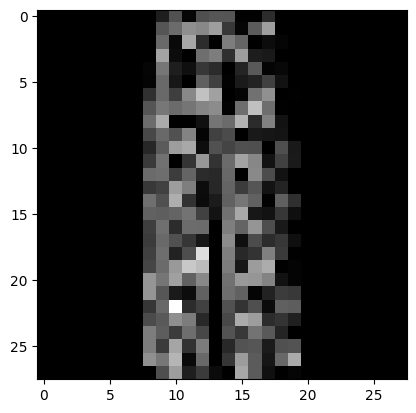

In [10]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
    }

M = len(test_data)
idx = torch.randint(0, M, (1,)).item()
X = test_data[idx][0]
actual_class = test_data[idx][1]

with torch.no_grad():
  predict = model(X.unsqueeze(dim=0))
  predict_class = torch.argmax(predict, axis=1).item()

print(f"Predict : {labels_map[predict_class]}")
print(f"Expected: {labels_map[actual_class]}")
plt.imshow(X[0], cmap='gray', vmin=0., vmax=1.)

#### Visualize

Trực quan hóa việc học của mạng CNN cho bộ lọc kernel tại convolutional layer đầu tiên. Thực hiện bằng cách lấy một ảnh ngẫu nhiên và forward pass ảnh đó qua convolutional layer đầu tiên để xem đáp ứng ảnh tương ứng.

In [11]:
print(model)

MyClassify(
  (network): Sequential(
    (0): Conv2d(1, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (5): ReLU()
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=128, out_features=128, bias=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=10, bias=True)
    (12): Softmax(dim=None)
  )
)


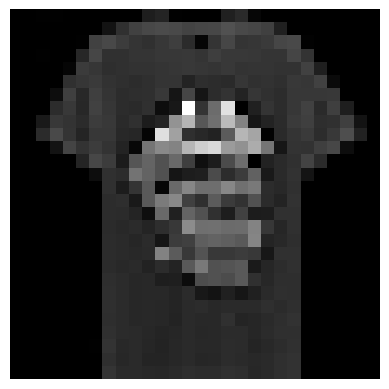

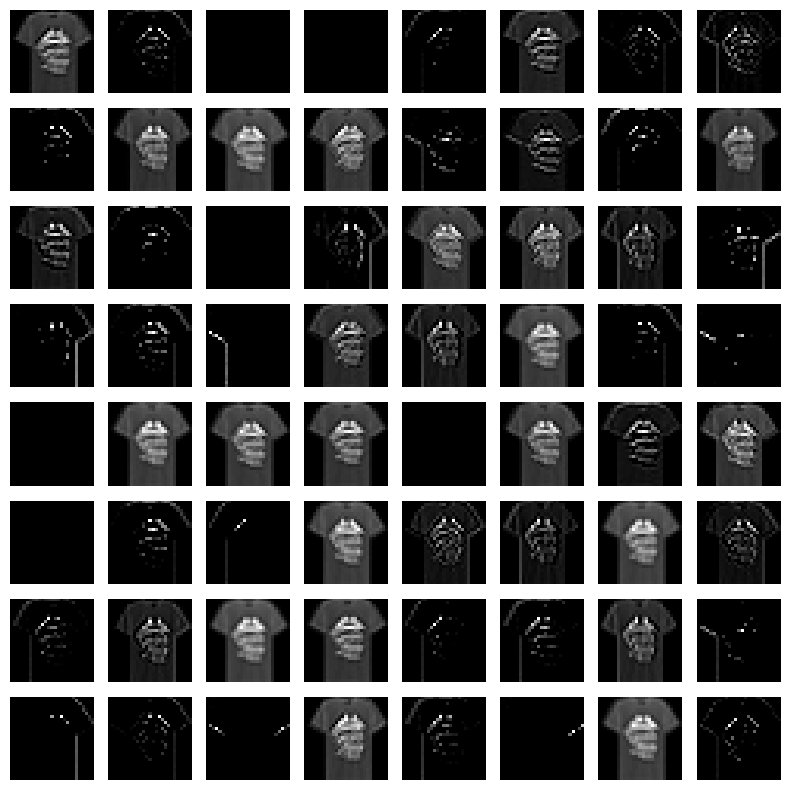

In [12]:
M = len(test_data)
idx = torch.randint(0, M, (1,)).item()
X = test_data[idx][0].unsqueeze(dim=0)
actual_class = test_data[idx][1]

plt.imshow(X.squeeze().detach(), cmap='gray', vmin=0.0, vmax=1.0)
plt.axis("off")
plt.show()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))

for i in range(8):
  for j in range(8):
    W = model.network[0].weight[i*8+j]
    X = test_data[idx][0]

    conv = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=2, bias=False)
    conv.weight.data = nn.Parameter(W.unsqueeze(dim=0))

    output = conv(X.unsqueeze(dim=0))
    output = torch.maximum(output, torch.zeros_like(output))

    axes[i,j].imshow(output.squeeze(0,1).detach(), cmap='gray')
    axes[i,j].axis("off")

plt.tight_layout()
plt.show()
# plt.imshow(output.squeeze(0,1).detach(), cmap='gray')